# Error analysis

In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sb
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Loading labels signification

In [2]:
file = open("class_list.txt","r")
labels_signification = []
s = file.readline()[2:-1]
while s != "":
    labels_signification.append(s)
    s = file.readline()[2:-1]

## Stage 1

In [3]:
video_ids_s1 = np.load("experiments/thumos/moe/stage1/video_id_165001.npy")
predictions_array_s1 = np.load("experiments/thumos/moe/stage1/predictions_array_165001.npy")
labels_array_s1 = np.load("experiments/thumos/moe/stage1/labels_array_165001.npy")

In [4]:
n = len(video_ids_s1)

## Stage 2

In [5]:
video_ids_s2_0 = np.load("experiments/thumos/moe/stage2/video_id_20001.npy")
predictions_array_s2_0 = np.load("experiments/thumos/moe/stage2/predictions_array_20001.npy")
labels_array_s2_0 = np.load("experiments/thumos/moe/stage2/labels_array_20001.npy")

Mapping between 1st stage results and 2nd stage results:

In [6]:
idxes = [np.where(video_ids_s2_0 == video_ids_s1[i])[0][0] for i in range(n)]

Reordering the 2nd stage results according to the 1st stage results'order:

In [7]:
video_ids_s2 = video_ids_s2_0[idxes]
predictions_array_s2 = predictions_array_s2_0[idxes]
labels_array_s2 = labels_array_s2_0[idxes]

## Comparing the different stages

Check ordering:

In [8]:
labels_array_s1 == labels_array_s2

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

Random observation:

In [9]:
idx = 1789
top_k = 5


print("Ground truth:")
print(np.where(labels_array_s1[idx]>0)[0])
print("Stage 1:")
print(np.argsort(predictions_array_s1[idx])[::-1][:top_k])
print("Stage 2:")
print(np.argsort(predictions_array_s2[idx])[::-1][:top_k])

print("\nGround truth:")
print([labels_signification[i] for i in np.where(labels_array_s1[idx]>0)[0]])
print("Stage 1:")
print([labels_signification[i] for i in np.argsort(predictions_array_s1[idx])[::-1][:top_k]]) 
print("Stage 2:")
print([labels_signification[i] for i in np.argsort(predictions_array_s2[idx])[::-1][:top_k]]) 

Ground truth:
[ 1 25]
Stage 1:
[25  1 21 20 24]
Stage 2:
[ 1 25 21 20 23]

Ground truth:
['BasketballDunk', ' Jump']
Stage 1:
[' Jump', 'BasketballDunk', ' Sit', ' Walk', ' Run']
Stage 2:
['BasketballDunk', ' Jump', ' Sit', ' Walk', ' Stand']


Metrics:

In [10]:
def ap(ground_truth, predictions, top_k=-1):
    numpos = np.size(np.where(ground_truth > 0))
    delta_recall = 1.0 / numpos
    sortidx = sorted(range(len(predictions)),
                     key=lambda k: predictions[k],
                     reverse=True)
    n = len(sortidx)
    if top_k>0:
        n = top_k
    poscount = 0
    
    
    ap = 0
    for i in range(n):
        if ground_truth[sortidx[i]] > 0:
            poscount += 1
            ap += poscount / (i + 1) * delta_recall
    return ap

In [11]:
def gap(labels, predictions, top_k=-1):
    
    labels = labels.flatten()
    predictions = predictions.flatten()
    
    return ap(labels, predictions, top_k)

In [12]:
gap(labels_array_s1, predictions_array_s1)

0.52747059722117

In [13]:
gap(labels_array_s1, predictions_array_s2)

0.547650032016107

In [14]:
def map_calc(labels, predictions):
    aps = [ap(labels[:,q],predictions[:,q]) for q in range(labels.shape[1])]
    return np.mean(aps)

In [15]:
map_calc(labels_array_s1, predictions_array_s1)

0.2953468673548357

In [16]:
map_calc(labels_array_s1, predictions_array_s2)

0.3119421212839163

Individual performances for both stages:

In [17]:
perf_gap_1 = [gap(labels_array_s1[i], predictions_array_s1[i]) for i in range(len(labels_array_s1))]
perf_gap_2 = [gap(labels_array_s1[i], predictions_array_s2[i]) for i in range(len(labels_array_s1))]

Effect of the CRF on individual performances:

In [18]:
diff_gap_2_1 = [perf_gap_2[i] - perf_gap_1[i] for i in range(n)]

In [19]:
mean(diff_gap_2_1)

0.009161682128451734

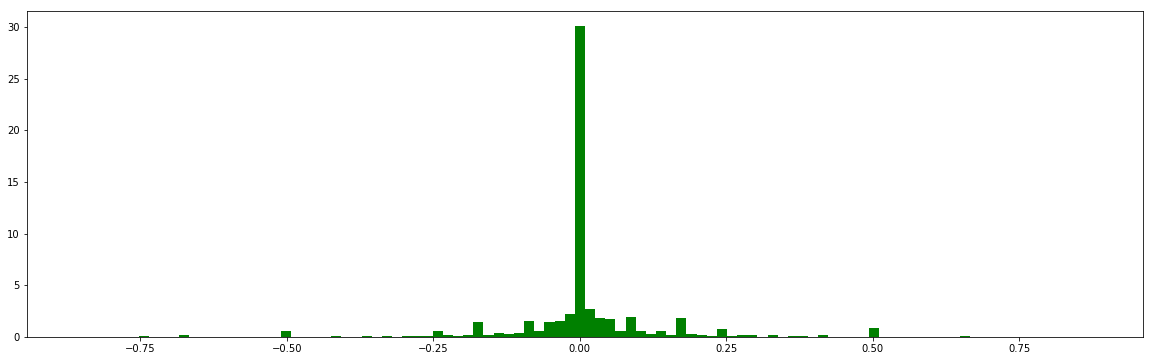

In [20]:
plt.figure(figsize=(20,6))
n, bins, patches = plt.hist(diff_gap_2_1, 100, normed=1, facecolor='green')

In [21]:
idxes_worst = np.argsort(diff_gap_2_1)

In [22]:
for idx in idxes_worst[-500:-1]:
    lab = np.where(labels_array_s1[idx]>0)[0]
    if len(lab)>1:
        print(idx)
        print(lab)

23227
[42 43]
42410
[ 1 25]
42467
[ 1 25]
23217
[42 43]
23218
[42 43]
24291
[12 24]
38741
[42 43]
38813
[42 43]
38918
[42 43]
38919
[42 43]
38920
[42 43]
38921
[42 43]
38924
[42 43]
38935
[42 43]
38939
[42 43]
42961
[ 1 25]
38943
[42 43]
3240
[20 21]
27033
[42 43]
38904
[42 43]
38903
[42 43]
38899
[42 43]
17696
[ 1 25]
27036
[42 43]
38658
[42 43]
49315
[13 21]
26840
[42 43]
36225
[42 43]
36226
[42 43]
36166
[42 43]
38832
[42 43]
36103
[42 43]
29254
[42 43]
26821
[42 43]
36104
[42 43]
28895
[12 21]
22358
[42 43]
8780
[62 63]
2013
[42 43]
2014
[42 43]
27034
[42 43]
27035
[42 43]
26875
[42 43]
27102
[42 43]
27101
[42 43]
45279
[42 43]
12450
[32 34]
38900
[42 43]
12453
[32 34]
45278
[42 43]
45154
[42 43]
12047
[42 43]
12048
[42 43]
42507
[ 1 25]
29253
[42 43]
42947
[ 1 25]
50740
[20 21]
17540
[20 21]
41351
[42 43]
26834
[42 43]
26823
[42 43]


In [271]:
10865/24

452.7083333333333

In [392]:
idx = idxes_worst[243]
top_k = 5

print("Video id:")
vid_id = video_ids_s1[idx]
print(vid_id)
start = float(vid_id[24:-1].split(",")[0])/30
end = float(vid_id[24:-1].split(",")[1])/30

print("From",
      int(start//60),
      ":",
      int(start%60),
      "to",
      int(end//60),
      ":",
      int(end%60))

print("\nGround truth:")
print(np.where(labels_array_s1[idx]>0)[0])
print("Stage 1:")
print(np.argsort(predictions_array_s1[idx])[::-1][:top_k])
print("Stage 2:")
print(np.argsort(predictions_array_s2[idx])[::-1][:top_k])

print("\nGround truth:")
print([labels_signification[i] for i in np.where(labels_array_s1[idx]>0)[0]])
print("Stage 1:")
print([labels_signification[i] for i in np.argsort(predictions_array_s1[idx])[::-1][:top_k]])
print(np.round(np.sort(predictions_array_s1[idx])[::-1][:top_k],2))
print("Stage 2:")
print([labels_signification[i] for i in np.argsort(predictions_array_s2[idx])[::-1][:top_k]])
print(np.round(np.sort(predictions_array_s2[idx])[::-1][:top_k],2))

Video id:
video_test_0001201.mp4-[6321, 6336]
From 3 : 30 to 3 : 31

Ground truth:
[14]
Stage 1:
[14 11 25 23 20]
Stage 2:
[11 14 25 20 26]

Ground truth:
[' PoleVault']
Stage 1:
[' PoleVault', ' HighJump', ' Jump', ' Stand', ' Walk']
[0.35 0.32 0.31 0.21 0.19]
Stage 2:
[' HighJump', ' PoleVault', ' Jump', ' Walk', ' Fall']
[0.34 0.34 0.26 0.18 0.17]


In [282]:
977/30

32.56666666666667

In [283]:
992/30

33.06666666666667

In [278]:
for i in range(2,35):
    if 19521/i==round(19521/i):
        print(i)
        print(19521/i)
        print()

3
6507.0
9
2169.0
27
723.0


In [247]:
21521/(21536-21521)

1434.7333333333333

In [248]:
457//60

7

In [249]:
457%60

37

In [254]:
labels_list_s1 = []
for i in range(len(labels_array_s1)):
    for j in np.where(labels_array_s1[i]>0)[0]:
        labels_list_s1.append(labels_signification[j])

### Worst 10% examples where the CRF hurts the 1st stage predictions:

In [25]:
idxes_worst_10 = idxes_worst[:int(0.1*len(idxes_worst))]

In [26]:
labels_list_s1_worst_10 = []
for i in idxes_worst_10:
    for j in np.where(labels_array_s1[i]>0)[0]:
        labels_list_s1_worst_10.append(labels_signification[j])
        
labels_array_s1_worst_10 = [labels_array_s1[i] for i in idxes_worst_10]
predictions_array_s1_worst_10 = [predictions_array_s1[i] for i in idxes_worst_10]
predictions_array_s2_worst_10 = [predictions_array_s2[i] for i in idxes_worst_10]

Count of the ground-truth labels of the instances that are mostly hurt by the CRF:

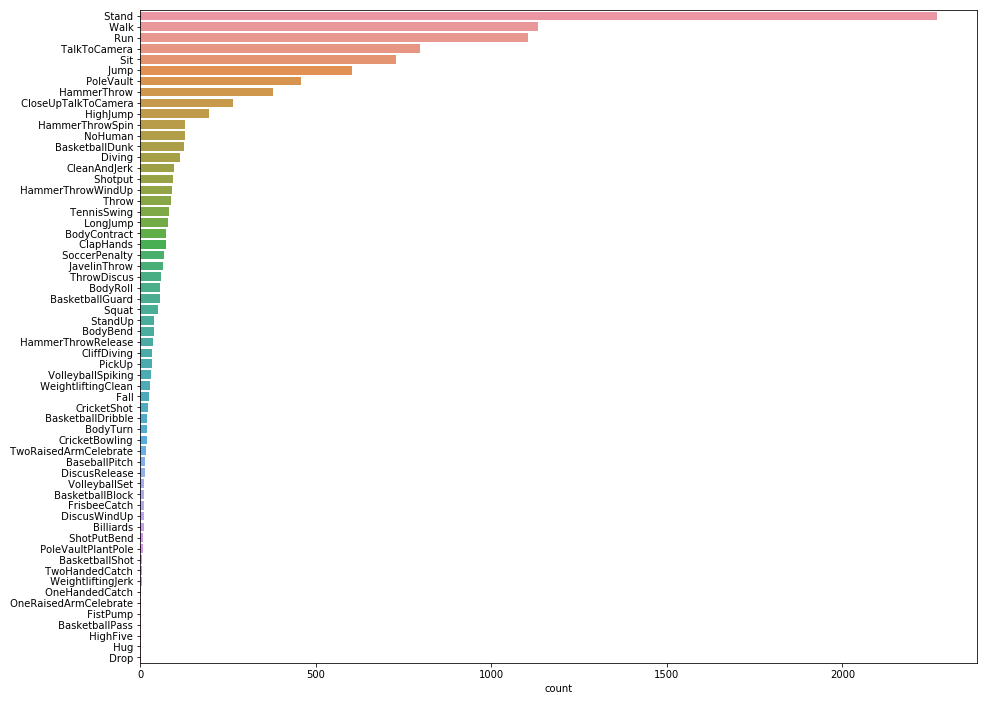

In [27]:
plt.figure(figsize=(15,12))

cnt_worst = Counter(labels_list_s1_worst_10)
order_labels = [cnt_worst.most_common()[i][0] for i in range(len(cnt_worst.most_common()))]
sb.countplot(y=labels_list_s1_worst_10, order=order_labels)

Distribution of labels on all examples:

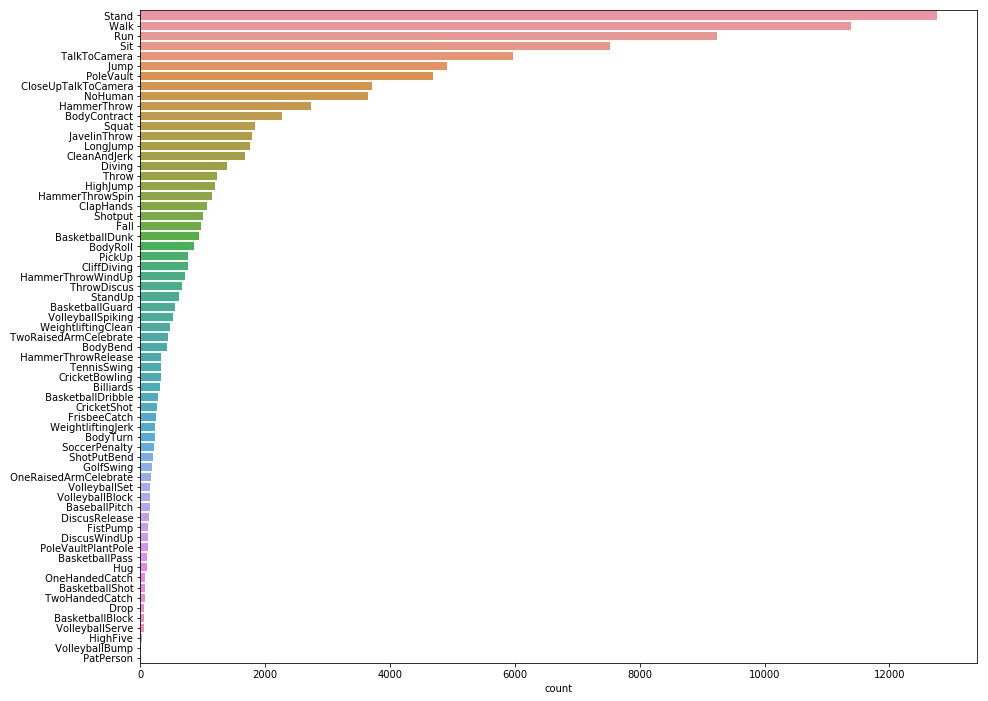

In [28]:
plt.figure(figsize=(15,12))

cnt = Counter(labels_list_s1)
order_labels = [cnt.most_common()[i][0] for i in range(len(cnt.most_common()))]
sb.countplot(y=labels_list_s1, order=order_labels)

Data-frame for counting original labels:

In [29]:
df = pd.DataFrame(data={"count_original":list(dict(cnt).values())},
                  index=list(dict(cnt).keys()))

df["count_original_prop"] = df["count_original"] / sum(df["count_original"])

Data-frame for counting badly CRF-impacted labels:

In [30]:
df_worst = pd.DataFrame(data={"count_worst":list(dict(cnt_worst).values())},
                  index=list(dict(cnt_worst).keys()))

df_worst["count_worst_prop"] = df_worst["count_worst"] / sum(df_worst["count_worst"])

Merge the 2 data-frames:

In [31]:
df_comp = pd.merge(df, df_worst, left_index=True, right_index=True)

In [32]:
df_comp["prop_worst/prop_original"] = df_comp["count_worst_prop"]/df_comp["count_original_prop"]
df_comp = df_comp.sort_values("prop_worst/prop_original", ascending=False)

Changes in the labels population induced by CRF on worst cases:

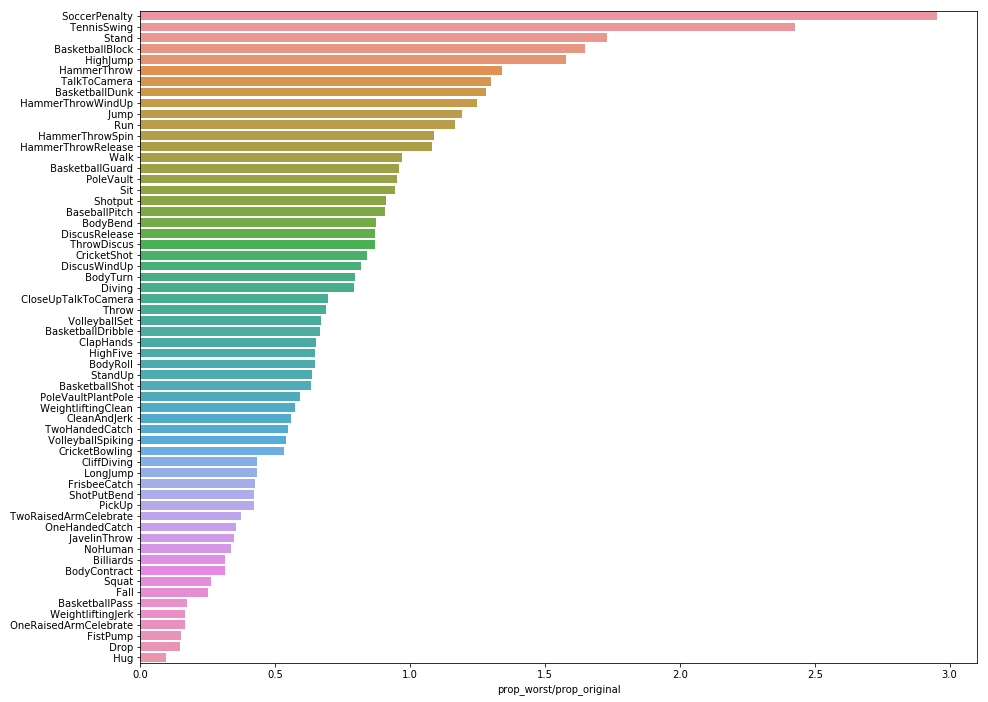

In [33]:
plt.figure(figsize=(15,12))

sb.barplot(y=df_comp.index.tolist(),
           x="prop_worst/prop_original",
           data=df_comp)

In [34]:
df_comp

,count_original,count_original_prop,count_worst,count_worst_prop,prop_worst/prop_original
SoccerPenalty,224,0.002317,68,0.006845,2.954886
TennisSwing,333,0.003444,83,0.008355,2.426128
Stand,12771,0.132075,2271,0.228609,1.730900
BasketballBlock,65,0.000672,11,0.001107,1.647249
HighJump,1203,0.012441,195,0.019630,1.577789
HammerThrow,2739,0.028326,377,0.037950,1.339767
TalkToCamera,5975,0.061792,798,0.080330,1.300004
BasketballDunk,943,0.009752,124,0.012482,1.279941
HammerThrowWindUp,710,0.007343,91,0.009160,1.247564
Jump,4916,0.050840,602,0.060600,1.191968


In [35]:
for i in range(len(labels_signification)):
    if labels_signification[i]==' SoccerPenalty':
        print(i)

16


In [36]:
label_id = 16

for i in range(len(labels_array_s1_worst_10)):
    if labels_array_s1_worst_10[i][label_id]:
        print("\nGround truth:")
        print([labels_signification[j] for j in np.where(labels_array_s1_worst_10[i]>0)[0]])
        print("Stage 1:")
        print([labels_signification[j] for j in np.argsort(predictions_array_s1_worst_10[i])[::-1][:top_k]])
        print([predictions_array_s1_worst_10[i][j] for j in np.argsort(predictions_array_s1_worst_10[i])[::-1][:top_k]])
        print("Stage 2:")
        print([labels_signification[j] for j in np.argsort(predictions_array_s2_worst_10[i])[::-1][:top_k]])
        print([predictions_array_s2_worst_10[i][j] for j in np.argsort(predictions_array_s2_worst_10[i])[::-1][:top_k]])



Ground truth:
[' SoccerPenalty', ' Run']
Stage 1:
[' SoccerPenalty', ' Run', ' Stand', ' Walk', ' NoHuman']
[0.456056, 0.36556628, 0.33440477, 0.20593996, 0.11342922]
Stage 2:
[' Stand', ' SoccerPenalty', ' Walk', ' Run', 'FrisbeeCatch']
[0.62028265, 0.47264832, 0.23700832, 0.1307938, 0.027429711]

Ground truth:
[' SoccerPenalty', ' Run']
Stage 1:
[' SoccerPenalty', ' Run', ' Stand', ' Walk', ' NoHuman']
[0.4508996, 0.36565074, 0.34662694, 0.20347533, 0.10756631]
Stage 2:
[' Stand', ' SoccerPenalty', ' Walk', ' Run', 'FrisbeeCatch']
[0.6329229, 0.47087854, 0.23670697, 0.133646, 0.028175456]

Ground truth:
[' SoccerPenalty', ' Run']
Stage 1:
[' SoccerPenalty', ' Run', ' Stand', ' Walk', ' NoHuman']
[0.53181297, 0.39083174, 0.27451947, 0.22546032, 0.13751811]
Stage 2:
[' Stand', ' SoccerPenalty', ' Walk', ' Run', ' FistPump']
[0.60667527, 0.5682125, 0.24966942, 0.11227509, 0.021989943]

Ground truth:
[' SoccerPenalty']
Stage 1:
[' SoccerPenalty', ' Run', ' Stand', ' Walk', ' NoHuman']
[

## Loading weights

In [166]:
STEP = "20001"

psi_0 = np.load("experiments/thumos/moe/stage2/psi_0_" + STEP + ".npy")
psi_1 = np.load("experiments/thumos/moe/stage2/psi_1_" + STEP + ".npy")

In [167]:
psi_0 = np.reshape(psi_0, (65,65))
psi_1 = np.reshape(psi_1, (65,65))

### Reproduction of updated probabilites:

In [168]:
def sig(x):
    return 1 / (1 + np.exp(-x))

In [169]:
def update_rule(prob, psi_0_rule=psi_0, psi_1_rule=psi_1):
    phi = -np.log( (1-prob)/(prob + 10e-4) + 10e-4 )
    delta = np.matmul(1-prob, psi_0_rule.T) + np.matmul(prob, psi_1_rule.T) + phi
    return sig(delta)

In [170]:
predictions_array_s1_updated = update_rule(predictions_array_s1)

In [171]:
np.max(np.abs(predictions_array_s1_updated - predictions_array_s2))

3.5762787e-07

In [172]:
gap(labels_array_s1, predictions_array_s1_updated)

0.5476500328672124

In [173]:
map_calc(labels_array_s1, predictions_array_s1_updated)

0.3119421195439725

### Trying different matrices for the update:

Matrix randomly sparse:

In [174]:
random_idxes = np.random.randint(65, size=10)

psi_0_sparse_1 = np.copy(psi_0)
psi_0_sparse_1[random_idxes,:] = 0
psi_0_sparse_1[:,random_idxes] = 0

psi_1_sparse_1 = np.copy(psi_1)
psi_1_sparse_1[random_idxes,:] = 0
psi_1_sparse_1[:,random_idxes] = 0

In [175]:
update_sparse_1 = update_rule(predictions_array_s1,
                              psi_0_rule=psi_0_sparse_1,
                              psi_1_rule=psi_1_sparse_1)

In [176]:
np.max(np.abs(update_sparse_1 - predictions_array_s2))

0.47118104

In [177]:
gap(labels_array_s1, update_sparse_1)

0.535755830579098

In [178]:
map_calc(labels_array_s1, update_sparse_1)

0.302484172168004

Sparsing on most common labels:

In [199]:
nb_sparse=25
most_common = [cnt.most_common()[i][0] for i in range(nb_sparse)]
idxes_sparse = [np.where(np.array(labels_signification)==most_common[i])[0][0] for i in range(nb_sparse)]

coeff = 0.5

psi_0_sparse_1 = np.copy(psi_0)
psi_0_sparse_1[idxes_sparse,:] = coeff*psi_0_sparse_1[idxes_sparse,:]
psi_0_sparse_1[:,idxes_sparse] = coeff*psi_0_sparse_1[:,idxes_sparse]

psi_1_sparse_1 = np.copy(psi_1)
psi_1_sparse_1[idxes_sparse,:] = coeff*psi_1_sparse_1[idxes_sparse,:]
psi_1_sparse_1[:,idxes_sparse] = coeff*psi_1_sparse_1[:,idxes_sparse]

In [200]:
update_sparse_1 = update_rule(predictions_array_s1,
                              psi_0_rule=psi_0_sparse_1,
                              psi_1_rule=psi_1_sparse_1)

for l in range(update_sparse_1.shape[0]):
    for i in range(update_sparse_1.shape[1]):
        if np.max(np.abs(update_sparse_1[l,i] - predictions_array_s1[l,i]))>0.3:
            update_sparse_1[l,i] = (update_sparse_1[l,i] + predictions_array_s1[l,i])/2

In [201]:
np.max(np.abs(update_sparse_1 - predictions_array_s2))

0.3574775

In [202]:
gap(labels_array_s1, update_sparse_1)

0.5384769464513681

In [203]:
map_calc(labels_array_s1, update_sparse_1)

0.308481601981818